### Hidden Markov Model

Using Brown Dataset

In [1]:
import nltk
from nltk.corpus import brown
import numpy as np
from nltk.tag import map_tag
from collections import defaultdict, Counter

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

start_tag = '^'

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
import os
print(os.getcwd())

/workspace/Assignment1/final_hmm


In [4]:
def calc_emission_prob(data):
    word_tag_count = defaultdict(Counter)
    tag_count = Counter()
    emission_prob = defaultdict(dict)

    for sentence in data:
        for word, tag in sentence:
            word_tag_count[word.lower()][tag] += 1
            tag_count[tag] += 1

    for word in word_tag_count:
        for tag in word_tag_count[word]:
          emission_prob[word][tag] = (word_tag_count[word][tag] + 1) / (tag_count[tag] + len(word_tag_count))
    emission_prob_list.append(emission_prob)


In [5]:
def calc_transition_prob(data):
    tag_tag_count = defaultdict(Counter)
    transition_prob = defaultdict(dict)
    start_tag_count = Counter()
    tag_count = Counter()

    for sentence in data:
        prev_tag = start_tag
        for word, tag in sentence:
            tag_tag_count[prev_tag][tag] += 1
            prev_tag = tag
            tag_count[tag] += 1

    for prev_tag in tag_tag_count:
        total_count = sum(tag_tag_count[prev_tag].values())
        for curr_tag in tag_tag_count[prev_tag]:
            transition_prob[prev_tag][curr_tag] = (tag_tag_count[prev_tag][curr_tag] + 1) / (total_count + len(tag_tag_count))

    transition_prob_list.append(transition_prob)

In [6]:
def viterbi_algo(sentence, fold_index):
    sentence = sentence.copy()
    sentence.append('.')
    # if re.search(r'[a-zA-Z]',sentence[-1]):
    #   sentence.append('.')
    #   print("Sentence didn't ended with a .")
    viterbi_table = [{} for _ in range(len(sentence))]
    backpointer = [{} for _ in range(len(sentence))]
    emission_prob = emission_prob_list[fold_index]
    transition_prob = transition_prob_list[fold_index]

    for tag in transition_prob[start_tag]:
        word = sentence[0].lower()
        viterbi_table[0][tag] = transition_prob[start_tag].get(tag, 1e-6) * emission_prob.get(word, {}).get(tag, 1e-6)
        backpointer[0][tag] = start_tag

    for t in range(1, len(sentence)):
        word = sentence[t].lower()
        for curr_tag in transition_prob:
            max_prob, best_prev_tag = max(
                (viterbi_table[t-1][prev_tag] * transition_prob[prev_tag].get(curr_tag, 1e-6) * emission_prob.get(word, {}).get(curr_tag, 1e-6), prev_tag)
                for prev_tag in viterbi_table[t-1]
            )
            viterbi_table[t][curr_tag] = max_prob
            backpointer[t][curr_tag] = best_prev_tag

    best_path = []
    best_last_tag = max(viterbi_table[-1], key=viterbi_table[-1].get)
    best_path.append(best_last_tag)
    for t in range(len(sentence) - 1, 0, -1):
        best_last_tag = backpointer[t][best_last_tag]
        best_path.insert(0, best_last_tag)
    best_path.pop()
    return best_path

In [7]:
import torch


import nltk
from nltk.corpus import brown
import numpy as np
from nltk.tag import map_tag
from collections import defaultdict, Counter

nltk.download('brown')
nltk.download('universal_tagset')

start_tag = '^'

data = brown.tagged_sents(tagset='universal')


tags = set(tag for sent in data for _, tag in sent)
sorted_tags = sorted(tags)
sorted_tags.append(start_tag)
print(tags)


sent_by_word = []
sent_by_tag = []
for sent in data:
    s = []
    t = []
    for word, tag in sent:
        s.append(word)
        t.append(tag)
    sent_by_word.append(s)
    sent_by_tag.append(t)
print(len(sent_by_word))
print(len(sent_by_tag))

data_X = sent_by_word
data_y = sent_by_tag



words = [word for sent in data for word, tag in sent]
words = set(words)
vocab_size = len(words)
print(vocab_size)


tag_to_idx = {c:i for i, c in enumerate(sorted_tags)}
idx_to_tag = {i:c for i, c in enumerate(sorted_tags)}





from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    data_X, data_y, test_size=0.2, random_state=42, shuffle=True
)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


{'DET', '.', 'VERB', 'NOUN', 'PRT', 'X', 'ADJ', 'ADV', 'CONJ', 'PRON', 'NUM', 'ADP'}
57340
57340
56057


In [8]:
def calc_acc(actual, predicted):
    correct = sum(1 for a, p in zip(actual, predicted) if a == p)
    total = len(actual)
    return (correct / total) * 100

In [9]:
emission_prob_list = []
transition_prob_list = []

### Building Emission & Transition Probabilities; then using Viterbi Algorithm

In [10]:
from tqdm import tqdm

tag_predicted = []
actual_tags = []

# Build training data as list of (word, tag) pairs per sentence
data_train = []
for words, tags in zip(X_train, y_train):
    sentence_pairs = [(w, t) for w, t in zip(words, tags)]
    data_train.append(sentence_pairs)

# Train HMM
calc_emission_prob(data_train)
calc_transition_prob(data_train)

# Evaluate on training data with tqdm
for sent, true_tags in tqdm(zip(X_train, y_train), total=len(X_train), desc="Evaluating on training data"):
    pred_tags = viterbi_algo(sent, 0)   # use fold=0 since no CV

    actual_tags.extend(true_tags)
    tag_predicted.extend(pred_tags)

# Compute accuracy
overall_accuracy = calc_acc(actual_tags, tag_predicted)
print(f"Training accuracy: {overall_accuracy:.2f}%")

Evaluating on training data: 100%|███| 45872/45872 [01:46<00:00, 429.78it/s]


Training accuracy: 96.76%


### Testing on Brown Dataset

In [11]:
import re
from collections import defaultdict, Counter
from tqdm import tqdm

# Initialize confusion matrix
per_pos_accuracy = defaultdict(lambda: defaultdict(int))
for each_tag1 in sorted_tags:
    for each_tag2 in sorted_tags:
        per_pos_accuracy[each_tag1][each_tag2] = 0

tag_predicted = []
actual_tags = []

def get_answer(input_words):
    # Use only the last fold
    pos_tags = viterbi_algo(input_words, 0)
    return pos_tags

# Evaluate on test set with tqdm
num_folds = len(emission_prob_list)

for sent, true_tags in tqdm(zip(X_test, y_test), total=len(X_test), desc="Evaluating"):
    # sent is already a list of words
    pred_tags = get_answer(sent)
    
    actual_tags.extend(true_tags)
    tag_predicted.extend(pred_tags)

    # Update confusion matrix
    for t_true, t_pred in zip(true_tags, pred_tags):
        per_pos_accuracy[t_true][t_pred] += 1

Evaluating: 100%|████████████████████| 11468/11468 [00:26<00:00, 440.80it/s]


In [12]:
# Compute overall accuracy
test_accuracy = calc_acc(actual_tags, tag_predicted)
print(f"Test accuracy: {test_accuracy:.2f}%")

Test accuracy: 95.41%


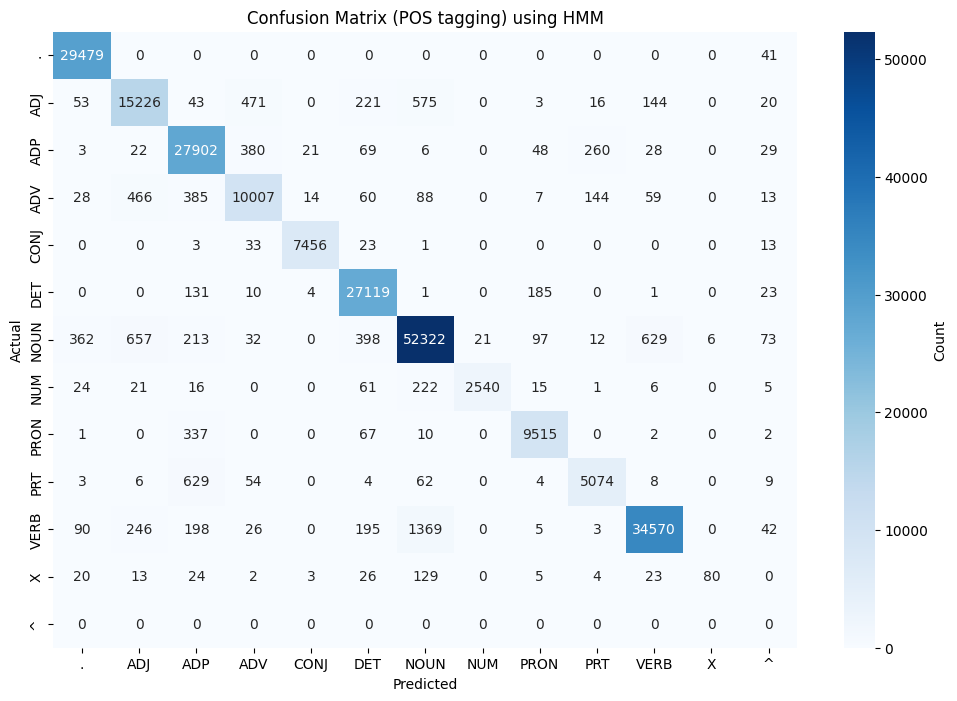

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert your nested dict into a pandas DataFrame
df_cm = pd.DataFrame.from_dict(per_pos_accuracy, orient='index')

# Ensure column order matches sorted_tags
df_cm = df_cm[sorted_tags]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=sorted_tags, yticklabels=df_cm.index,
            cbar_kws={'label': 'Count'})

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (POS tagging) using HMM")
plt.show()

In [14]:
len(emission_prob_list)

1

In [15]:
sorted_tags

['.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X',
 '^']

In [16]:
per_pos_precision = defaultdict(dict)
for k1,p1 in per_pos_accuracy.items():
  if k1 != '^':
    i = 0
    for k2,p2 in p1.items():
      i += p2
    for k2,p2 in p1.items():
      per_pos_precision[k1][k2] = p2/i
print('\t',end="")
for tags in sorted_tags:
  print(tags,end='\t')
print()
for k1,p1 in per_pos_precision.items():
  print(k1, end='\t')
  for k2,p2 in p1.items():
    print(round(p2,2), end='\t')
  print()

	.	ADJ	ADP	ADV	CONJ	DET	NOUN	NUM	PRON	PRT	VERB	X	^	
.	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
ADJ	0.0	0.91	0.0	0.03	0.0	0.01	0.03	0.0	0.0	0.0	0.01	0.0	0.0	
ADP	0.0	0.0	0.97	0.01	0.0	0.0	0.0	0.0	0.0	0.01	0.0	0.0	0.0	
ADV	0.0	0.04	0.03	0.89	0.0	0.01	0.01	0.0	0.0	0.01	0.01	0.0	0.0	
CONJ	0.0	0.0	0.0	0.0	0.99	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
DET	0.0	0.0	0.0	0.0	0.0	0.99	0.0	0.0	0.01	0.0	0.0	0.0	0.0	
NOUN	0.01	0.01	0.0	0.0	0.0	0.01	0.95	0.0	0.0	0.0	0.01	0.0	0.0	
NUM	0.01	0.01	0.01	0.0	0.0	0.02	0.08	0.87	0.01	0.0	0.0	0.0	0.0	
PRON	0.0	0.0	0.03	0.0	0.0	0.01	0.0	0.0	0.96	0.0	0.0	0.0	0.0	
PRT	0.0	0.0	0.11	0.01	0.0	0.0	0.01	0.0	0.0	0.87	0.0	0.0	0.0	
VERB	0.0	0.01	0.01	0.0	0.0	0.01	0.04	0.0	0.0	0.0	0.94	0.0	0.0	
X	0.06	0.04	0.07	0.01	0.01	0.08	0.39	0.0	0.02	0.01	0.07	0.24	0.0	


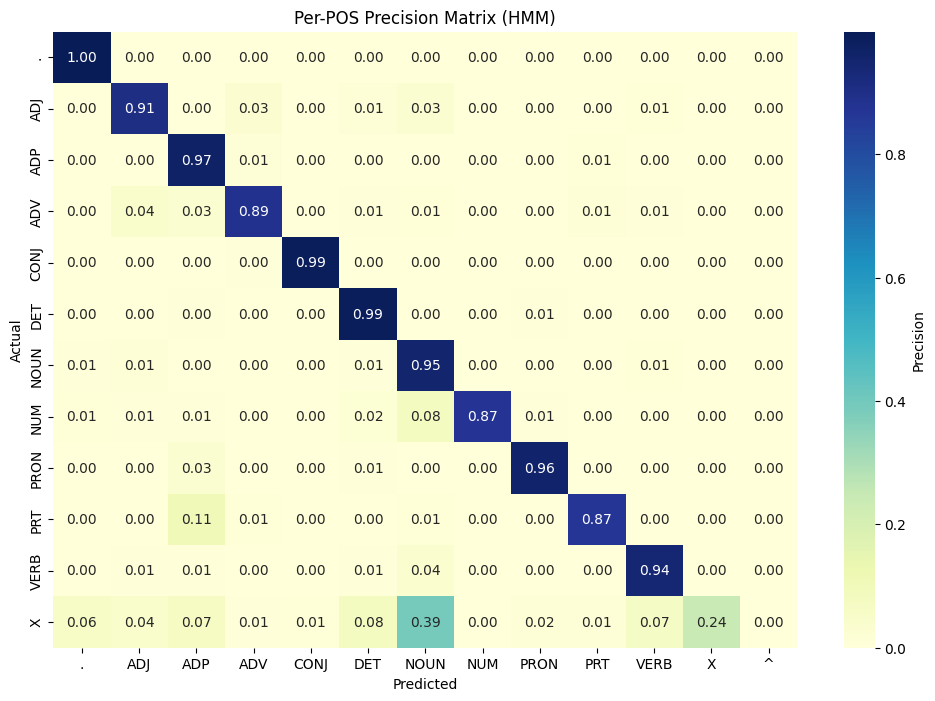

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert your precision dict into a DataFrame
df_prec = pd.DataFrame.from_dict(per_pos_precision, orient='index')

# Ensure column order matches sorted_tags
df_prec = df_prec[sorted_tags]

# Plot heatmap (normalized values, 0–1)
plt.figure(figsize=(12, 8))
sns.heatmap(df_prec, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=sorted_tags, yticklabels=df_prec.index,
            cbar_kws={'label': 'Precision'})

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Per-POS Precision Matrix (HMM)")
plt.show()

In [18]:
viterbi_algo(['I','live','in','Mumbai'],0)

['PRON', 'VERB', 'ADP', 'NOUN']

In [19]:
len(data)

57340

In [20]:
emission_prob_list[0]['i']

{'PRON': 0.04857078657000603, 'NOUN': 2.632637940825821e-05}

In [21]:
import json
# Convert to JSON
json_data = json.dumps(emission_prob_list, indent=4)

# Save to a file
with open('emission_prob_list.json', 'w') as f:
    f.write(json_data)

In [22]:
import json

# Load JSON from file
with open('emission_prob_list.json', 'r') as f:
    json_data = f.read()

# Convert JSON to Python object
emission_prob_list = json.loads(json_data)

In [23]:
import json
# Convert to JSON
json_data = json.dumps(transition_prob_list, indent=4)

# Save to a file
with open('transition_prob_list.json', 'w') as f:
    f.write(json_data)

In [24]:
import json

# Load JSON from file
with open('transition_prob_list.json', 'r') as f:
    json_data = f.read()

# Convert JSON to Python object
transition_prob_list = json.loads(json_data)

In [25]:
transition_prob_list[0]['^']["NOUN"]

0.1409175111692274

### HMM Analysis (Brown Dataset)

In [48]:
len(actual_tags)

231927

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(actual_tags, tag_predicted)
precision = precision_score(actual_tags, tag_predicted, average="weighted")
recall = recall_score(actual_tags, tag_predicted, average="weighted")
f1 = f1_score(actual_tags, tag_predicted, average="weighted")

print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy : 0.95
Precision: 0.95
Recall   : 0.95
F1 Score : 0.95


In [40]:
from sklearn.metrics import classification_report
print(classification_report(actual_tags, tag_predicted))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           .       0.98      1.00      0.99     29520
         ADJ       0.91      0.91      0.91     16772
         ADP       0.93      0.97      0.95     28768
         ADV       0.91      0.89      0.90     11271
        CONJ       0.99      0.99      0.99      7529
         DET       0.96      0.99      0.97     27474
        NOUN       0.96      0.95      0.95     54822
         NUM       0.99      0.87      0.93      2911
        PRON       0.96      0.96      0.96      9934
         PRT       0.92      0.87      0.89      5853
        VERB       0.97      0.94      0.96     36744
           X       0.93      0.24      0.39       329
           ^       0.00      0.00      0.00         0

    accuracy                           0.95    231927
   macro avg       0.88      0.81      0.83    231927
weighted avg       0.96      0.95      0.95    231927



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Per-POS Confusion Matrix

In [47]:
from sklearn.metrics import confusion_matrix

labels = sorted_tags
cm = confusion_matrix(actual_tags, tag_predicted, labels=labels)

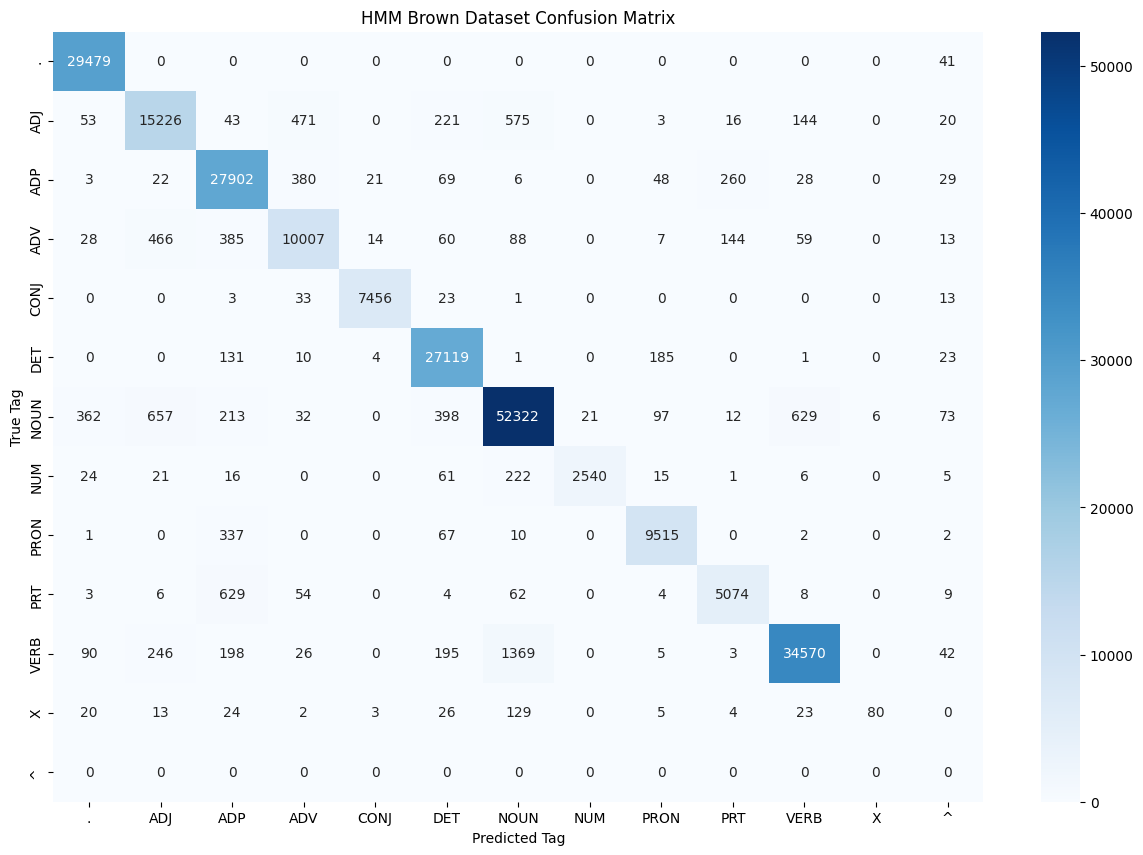

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Tag")
plt.ylabel("True Tag")
plt.title("HMM Brown Dataset Confusion Matrix")
plt.show()

In [49]:
per_pos_accur = defaultdict(dict)
per_pos_counts = per_pos_accuracy
for true_tag, pred_dict in per_pos_counts.items():
    total = sum(pred_dict.values())
    correct = pred_dict.get(true_tag, 0)
    per_pos_accur[true_tag] = {
        "Accuracy": correct / total if total > 0 else 0.0,
        "Support": total
    }

# Make fancy DataFrame
per_pos_acc_df = pd.DataFrame.from_dict(per_pos_accur, orient="index")
per_pos_acc_df = per_pos_acc_df.sort_values("Support", ascending=False)

# Round accuracy to 3 decimals
per_pos_acc_df["Accuracy"] = per_pos_acc_df["Accuracy"].round(3)

# Pretty print
print(per_pos_acc_df)

# Convert to LaTeX table
latex_table = per_pos_acc_df.to_latex(
    index=True,
    header=True,
    caption="Per-POS Accuracy for HMM testing on Penn Treebank",
    label="tab:per_pos_acc",
    float_format="%.3f",
    column_format="lrr"  # left align index, right align numeric
)

print(latex_table)

      Accuracy  Support
NOUN     0.954    54822
VERB     0.941    36744
.        0.999    29520
ADP      0.970    28768
DET      0.987    27474
ADJ      0.908    16772
ADV      0.888    11271
PRON     0.958     9934
CONJ     0.990     7529
PRT      0.867     5853
NUM      0.873     2911
X        0.243      329
^        0.000        0
\begin{table}
\caption{Per-POS Accuracy for HMM testing on Penn Treebank}
\label{tab:per_pos_acc}
\begin{tabular}{lrr}
\toprule
 & Accuracy & Support \\
\midrule
NOUN & 0.954 & 54822 \\
VERB & 0.941 & 36744 \\
. & 0.999 & 29520 \\
ADP & 0.970 & 28768 \\
DET & 0.987 & 27474 \\
ADJ & 0.908 & 16772 \\
ADV & 0.888 & 11271 \\
PRON & 0.958 & 9934 \\
CONJ & 0.990 & 7529 \\
PRT & 0.867 & 5853 \\
NUM & 0.873 & 2911 \\
X & 0.243 & 329 \\
^ & 0.000 & 0 \\
\bottomrule
\end{tabular}
\end{table}

